###Scraping discrete stocks trading data

In [1]:
#Installing required Packages 
!pip install yfinance
!pip install holidays
!pip install tflearn

#Importing required modules
import pandas as pd
import numpy as np
import yfinance as yf
from pandas_datareader import data as pdr

import requests
from bs4 import BeautifulSoup

from time import sleep
from random import randint
import time

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import date
import holidays

import plotly.graph_objects as go

#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


from __future__ import print_function
#import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

import tflearn
import tqdm
%config InlineBackend.figure_format = 'retina'

     |████████████████████████████████| 6.3 MB 7.9 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.63-py2.py3-none-any.whl size=23918 sha256=82643a621d1ccb8c395f52a9c54a18e5cfc078be6124dd098e8b69d34a90f2ac
  Stored in directory: /root/.cache/pip/wheels/fe/87/8b/7ec24486e001d3926537f5f7801f57a74d181be25b11157983
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
     |████████████████████████████████| 107 kB 5.3 MB/s 
  Created wheel for tflearn: filename=tflearn-0.5.0-py3-none-any.whl size=127299 sha256=a869796d9967c6f248f58a729952b51f72484b474c8e0fc647fb74a87fddd263
  Stored in directory: /root/.cache/pip/wheels/5f/14/2e/1d8e28cc47a5a931a2fb82438c9e37ef9246cc6a3774520271
Successfully built tflearn
Instructions for updating:
non-resource variables are not supported in the long term


**function** to get stocks data from data readerfrom Yahoo Finance

In [2]:
def stock_returns(ticker_list, start, end):
    list_of_df = []
    not_found = []
    
    for ticker in ticker_list:
        try:
            df= yf.download(ticker, start, end)
            df = df.reset_index()
            df.rename(columns={'Date':'date'})
            df['ticker'] = [ticker] * len(df)
            list_of_df.append(df)
        except ValueError:
            print("Not Found: "+ticker)
            not_found.append(ticker)
    
    return list_of_df, not_found

function to get stocks data

In [3]:
def get_stocks_data(ticker_set, start, end):
    #Stocks data for a year from Yahoo Data
    stocks_1, not_found = stock_returns(ticker_set, start, end)
    return pd.concat(stocks_1)

Generate Data [ getting the Open, Low, High and Close values +Ticker ]

In [4]:
#Project QFolio
tickers = ['XOM', 'BAC', 'IBM', 'PFE', 'TSLA']
df = get_stocks_data(tickers, start='2015-01-01', end='2020-12-31')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [5]:
#stocks_final = stocks_final[['Date', 'Open', 'High', 'Low', 'Close', 'ticker']]
df = df[['Date', 'Open', 'High', 'Low', 'Close', 'ticker']]

In [6]:
df.sample(5)

,Date,Open,High,Low,Close,ticker
421,2016-09-02,32.998100,33.055027,32.836811,32.988613,PFE
1318,2020-03-30,108.089996,113.459999,107.809998,112.930000,IBM
429,2016-09-15,15.640000,15.750000,15.580000,15.670000,BAC
1192,2019-09-27,70.699997,71.669998,70.629997,71.480003,XOM
317,2016-04-07,149.070007,149.600006,148.000000,148.250000,IBM


In [7]:
df.to_csv('stocks.csv')


###Explorartory Data Analysis for the discrete stock

exploring the dataset for basic information

In [8]:
df_stocks = pd.read_csv("stocks.csv")

In [9]:
print("Earliest Date for stocks", df_stocks['Date'].min())
print("Latest Date for stocks", df_stocks['Date'].max())

Earliest Date for stocks 2015-01-02
Latest Date for stocks 2020-12-30


In [10]:
print("Number of Holdings in stocks data:", len(set(df_stocks['ticker'])))

Number of Holdings in stocks data: 5


In [11]:
#checking null values for stocks dataframe
pd.pivot_table(df_stocks, values ='Close', index =['Date'], columns =['ticker']).isnull().values.any()

False

In [12]:
stocks_null = pd.pivot_table(df_stocks, values ='Close', index =['Date'], columns =['ticker'])
stocks_null[stocks_null.isnull().any(axis=1)].sample(0)

ticker,BAC,IBM,PFE,TSLA,XOM
Date,,,,,


There are no null values found in Stocks Price Data

###collecting the data for week days excluding national holidays

In [13]:
# Select country
us_holidays = holidays.US()

df_stocks['Holiday'] = df_stocks.Date.apply(lambda x: x in us_holidays)

In [14]:
df_stocks['Date'] = pd.to_datetime(df_stocks['Date'])
df_stocks['Day'] = df_stocks['Date'].dt.day_name()

In [15]:
df_stocks = df_stocks.loc[df_stocks['Holiday'] == False]
df_stocks = df_stocks.loc[~df_stocks.Day.isin(['Saturday', 'Sunday'])]

### calculating the returns for stocks and crypto currency data

In [16]:
list_of_stock = []

for tick in list(set(df_stocks['ticker'])):
    df = df_stocks.loc[df_stocks['ticker'] == tick]
    df['daily return'] = df['Close'].pct_change(1)
    list_of_stock.append(df)
    
returns_stocks = pd.concat(list_of_stock)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [17]:
for ticker in list(set(returns_stocks['ticker'])):
    temp = returns_stocks.loc[returns_stocks['ticker'] == ticker]
    print(ticker+' has data for '+str(len(set(temp.index)))+' days')

BAC has data for 1498 days
PFE has data for 1498 days
TSLA has data for 1498 days
XOM has data for 1498 days
IBM has data for 1498 days


##Plotting interactive returns for discrete stocks data for different years

In [18]:
# Reshaping data

returns_stocks['Date'] = pd.to_datetime(returns_stocks['Date'])
filter_mask = returns_stocks['Date'] > pd.Timestamp(2016, 1, 1)
filtered_df = returns_stocks[filter_mask]
returns_stocks_reshaped = filtered_df.pivot(index='Date', columns='ticker', values='daily return')
returns_stocks_reshaped = returns_stocks_reshaped.reset_index()

In [19]:
# Showing muliple currencies on the same graph

fig = go.Figure()

fig.add_trace(go.Scatter(
                x = returns_stocks_reshaped.Date,
                y = returns_stocks_reshaped['XOM'],
                name = "Exxon",
                line_color ='red',
                opacity = 0.5))

fig.add_trace(go.Scatter(
                x = returns_stocks_reshaped.Date,
                y = returns_stocks_reshaped['BAC'],
                name = "Bank of America",
                line_color ='blue',
                opacity = 0.5))

fig.add_trace(go.Scatter(
                x = returns_stocks_reshaped.Date,
                y = returns_stocks_reshaped['IBM'],
                name = "IBM",
                line_color ='green',
                opacity = 0.5))
fig.add_trace(go.Scatter(
                x = returns_stocks_reshaped.Date,
                y = returns_stocks_reshaped['PFE'],
                name = "Pfizer",
                line_color ='black',
                opacity = 0.5))
fig.add_trace(go.Scatter(
                x = returns_stocks_reshaped.Date,
                y = returns_stocks_reshaped['TSLA'],
                name = "TESLA",
                line_color ='yellow',
                opacity = 0.5))


# Use date string to set xaxis range
fig.update_layout(xaxis_range = ['2020-01-01','2020-12-31'],
                  title_text = 'Returns for discrete stocks [Year - 2020]')
fig.update_yaxes(title_text = 'Returns')
fig.update_xaxes(title_text = 'Time period')
fig.show()

In [20]:
# Showing muliple currencies on the same graph

fig = go.Figure()

fig.add_trace(go.Scatter(
                x = returns_stocks_reshaped.Date,
                y = returns_stocks_reshaped['XOM'],
                name = "Exxon",
                line_color ='red',
                opacity = 0.5))

fig.add_trace(go.Scatter(
                x = returns_stocks_reshaped.Date,
                y = returns_stocks_reshaped['BAC'],
                name = "Bank of America",
                line_color ='blue',
                opacity = 0.5))

fig.add_trace(go.Scatter(
                x = returns_stocks_reshaped.Date,
                y = returns_stocks_reshaped['IBM'],
                name = "IBM",
                line_color ='green',
                opacity = 0.5))
fig.add_trace(go.Scatter(
                x = returns_stocks_reshaped.Date,
                y = returns_stocks_reshaped['PFE'],
                name = "Pfizer",
                line_color ='black',
                opacity = 0.5))
fig.add_trace(go.Scatter(
                x = returns_stocks_reshaped.Date,
                y = returns_stocks_reshaped['TSLA'],
                name = "TESLA",
                line_color ='yellow',
                opacity = 0.5))


# Use date string to set xaxis range
fig.update_layout(xaxis_range = ['2019-01-01','2019-12-31'],
                  title_text = 'Returns for discrete stocks [Year - 2019]')
fig.update_yaxes(title_text = 'Returns')
fig.update_xaxes(title_text = 'Time period')
fig.show()

In [21]:
fig = go.Figure()

fig.add_trace(go.Scatter(
                x = returns_stocks_reshaped.Date,
                y = returns_stocks_reshaped['XOM'],
                name = "Exxon",
                line_color ='red',
                opacity = 0.5))

fig.add_trace(go.Scatter(
                x = returns_stocks_reshaped.Date,
                y = returns_stocks_reshaped['BAC'],
                name = "Bank of America",
                line_color ='blue',
                opacity = 0.5))

fig.add_trace(go.Scatter(
                x = returns_stocks_reshaped.Date,
                y = returns_stocks_reshaped['IBM'],
                name = "IBM",
                line_color ='green',
                opacity = 0.5))
fig.add_trace(go.Scatter(
                x = returns_stocks_reshaped.Date,
                y = returns_stocks_reshaped['PFE'],
                name = "Pfizer",
                line_color ='black',
                opacity = 0.5))
fig.add_trace(go.Scatter(
                x = returns_stocks_reshaped.Date,
                y = returns_stocks_reshaped['TSLA'],
                name = "TESLA",
                line_color ='yellow',
                opacity = 0.5))


# Use date string to set xaxis range
fig.update_layout(xaxis_range = ['2018-01-01','2018-12-31'],
                  title_text = 'Returns for discrete stocks [Year - 2018]')
fig.update_yaxes(title_text = 'Returns')
fig.update_xaxes(title_text = 'Time period')
fig.show()

In [22]:
fig = go.Figure()

fig.add_trace(go.Scatter(
                x = returns_stocks_reshaped.Date,
                y = returns_stocks_reshaped['XOM'],
                name = "Exxon",
                line_color ='red',
                opacity = 0.5))

fig.add_trace(go.Scatter(
                x = returns_stocks_reshaped.Date,
                y = returns_stocks_reshaped['BAC'],
                name = "Bank of America",
                line_color ='blue',
                opacity = 0.5))

fig.add_trace(go.Scatter(
                x = returns_stocks_reshaped.Date,
                y = returns_stocks_reshaped['IBM'],
                name = "IBM",
                line_color ='green',
                opacity = 0.5))
fig.add_trace(go.Scatter(
                x = returns_stocks_reshaped.Date,
                y = returns_stocks_reshaped['PFE'],
                name = "Pfizer",
                line_color ='black',
                opacity = 0.5))
fig.add_trace(go.Scatter(
                x = returns_stocks_reshaped.Date,
                y = returns_stocks_reshaped['TSLA'],
                name = "TESLA",
                line_color ='yellow',
                opacity = 0.5))



# Use date string to set xaxis range
fig.update_layout(xaxis_range = ['2017-01-01','2017-12-31'],
                  title_text = 'Returns for discrete stocks [Year - 2017]')
fig.update_yaxes(title_text = 'Returns')
fig.update_xaxes(title_text = 'Time period')

fig.show()

In [23]:
fig = go.Figure()

fig.add_trace(go.Scatter(
                x = returns_stocks_reshaped.Date,
                y = returns_stocks_reshaped['XOM'],
                name = "Exxon",
                line_color ='red',
                opacity = 0.5))

fig.add_trace(go.Scatter(
                x = returns_stocks_reshaped.Date,
                y = returns_stocks_reshaped['BAC'],
                name = "Bank of America",
                line_color ='blue',
                opacity = 0.5))

fig.add_trace(go.Scatter(
                x = returns_stocks_reshaped.Date,
                y = returns_stocks_reshaped['IBM'],
                name = "IBM",
                line_color ='green',
                opacity = 0.5))
fig.add_trace(go.Scatter(
                x = returns_stocks_reshaped.Date,
                y = returns_stocks_reshaped['PFE'],
                name = "Pfizer",
                line_color ='black',
                opacity = 0.5))
fig.add_trace(go.Scatter(
                x = returns_stocks_reshaped.Date,
                y = returns_stocks_reshaped['TSLA'],
                name = "TESLA",
                line_color ='yellow',
                opacity = 0.5))


# Use date string to set xaxis range
fig.update_layout(xaxis_range = ['2016-01-01','2016-12-31'],
                  title_text = 'Returns for discrete stocks [Year - 2016]')
fig.update_yaxes(title_text = 'Returns')
fig.update_xaxes(title_text = 'Time period')
fig.show()

In [24]:
fig = go.Figure()

fig.add_trace(go.Scatter(
                x = returns_stocks_reshaped.Date,
                y = returns_stocks_reshaped['XOM'],
                name = "Exxon",
                line_color ='red',
                opacity = 0.5))

fig.add_trace(go.Scatter(
                x = returns_stocks_reshaped.Date,
                y = returns_stocks_reshaped['BAC'],
                name = "Bank of America",
                line_color ='blue',
                opacity = 0.5))

fig.add_trace(go.Scatter(
                x = returns_stocks_reshaped.Date,
                y = returns_stocks_reshaped['IBM'],
                name = "IBM",
                line_color ='green',
                opacity = 0.5))
fig.add_trace(go.Scatter(
                x = returns_stocks_reshaped.Date,
                y = returns_stocks_reshaped['PFE'],
                name = "Pfizer",
                line_color ='black',
                opacity = 0.5))
fig.add_trace(go.Scatter(
                x = returns_stocks_reshaped.Date,
                y = returns_stocks_reshaped['TSLA'],
                name = "TESLA",
                line_color ='yellow',
                opacity = 0.5))




# Use date string to set xaxis range
fig.update_layout(xaxis_range = ['2015-01-01','2015-12-31'],
                  title_text = 'Returns for discrete stocks [Year - 2015]')
fig.update_yaxes(title_text = 'Returns')
fig.update_xaxes(title_text = 'Time period')
fig.show()

### generating heat maps /  correlation plots

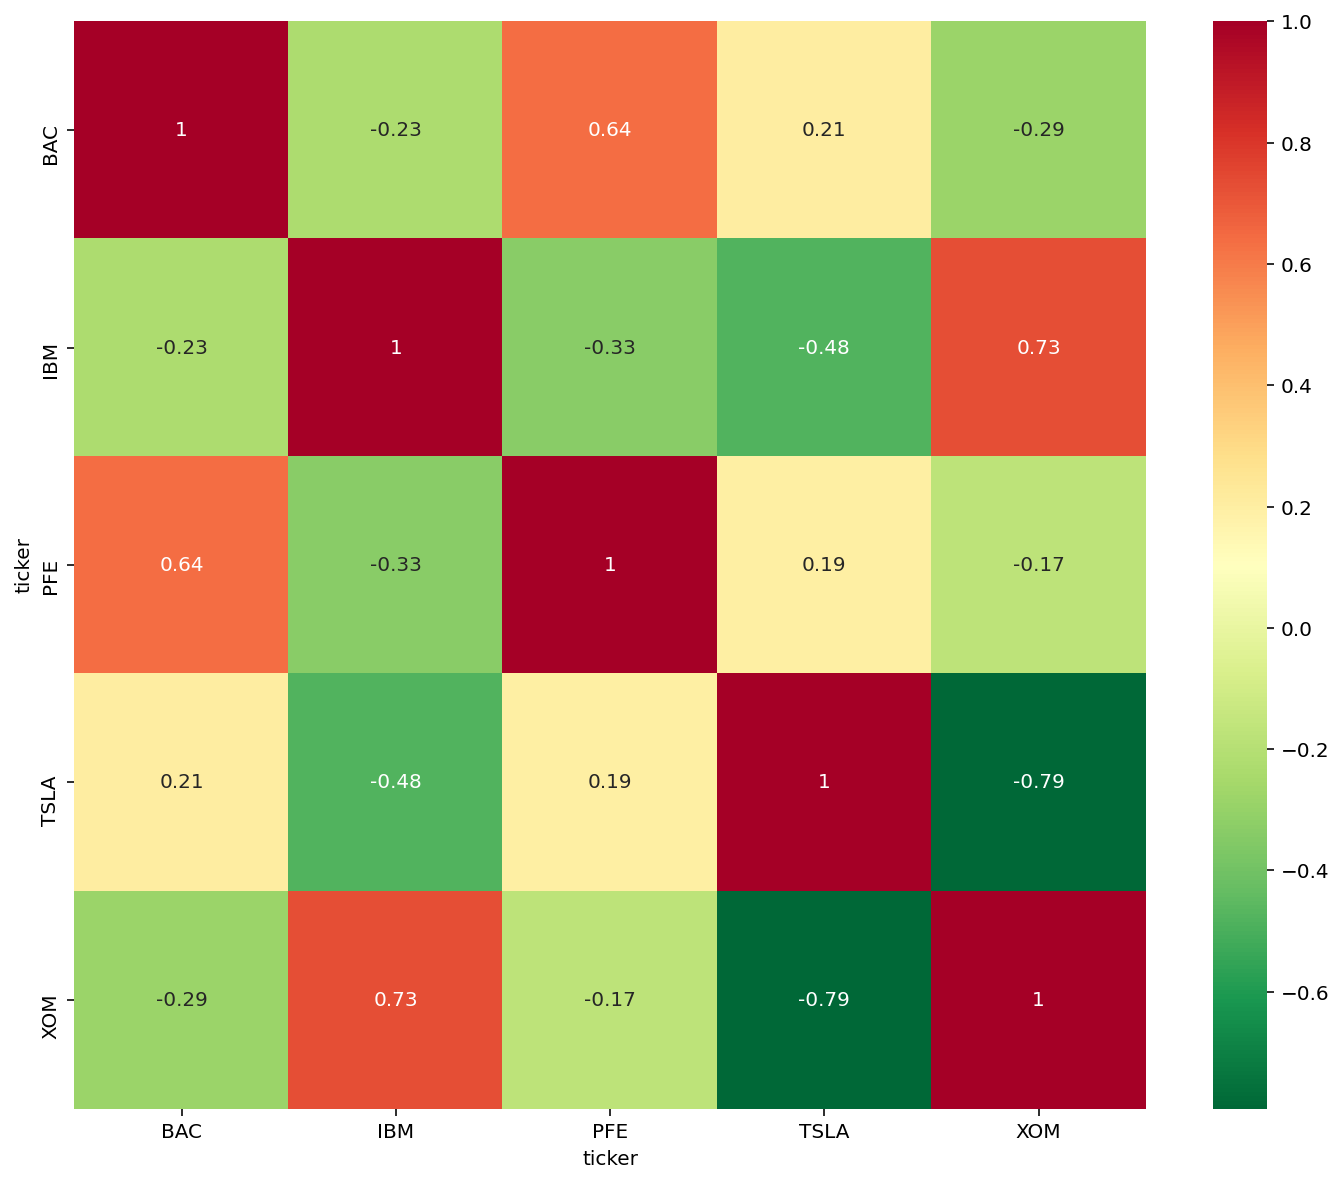

In [25]:
df_stocks.set_index('Date', inplace=True)
corr_df = pd.pivot_table(df_stocks, values ='Close', index =['Date'], columns =['ticker'])
correlation_stocks = corr_df.corr()
plt.figure(figsize=(12, 10))
sns_plot = sns.heatmap(correlation_stocks, annot=True, cmap="RdYlGn_r")
plt.savefig('Correlation.png')

###Data Preprocessing 

In [26]:
#Number of days stocks are traded in a year
nbr_trading_days = 252

#reading stock data
stocks_data_file_path = 'stocks.csv'
stocks_data = pd.read_csv(stocks_data_file_path)
print(stocks_data)
stocks_data  = stocks_data.sort_values(['ticker', 'Date'])
print('stocks considered : ' + str(np.unique(stocks_data['ticker'])))

#Calculating Mean Returns and Covariance Matrix
pivot_table = pd.pivot_table(stocks_data, values='Close', index=['Date'], columns=['ticker'])
returns = pivot_table.pct_change().dropna()
stocks_returns_mean = returns.mean()
stocks_covariance_matrix = returns.cov()



def get_input_data(data_table, ticker_column_name):
    open_values = list()
    close_values = list()
    high_values = list()
    low_values = list()

    for ticker in np.unique(data_table[ticker_column_name]):
        open_value_list = data_table['Open'].loc[data_table[ticker_column_name]==ticker]
        open_values.append(open_value_list[1:].reset_index(drop = True) / open_value_list[:-1].reset_index(drop = True))
        close_values.append(data_table['Close'].loc[data_table[ticker_column_name]==ticker][:-1] / open_value_list[:-1])
        high_values.append(data_table['High'].loc[data_table[ticker_column_name]==ticker][:-1] / open_value_list[:-1])
        low_values.append(data_table['Low'].loc[data_table[ticker_column_name]==ticker][:-1] / open_value_list[:-1])
    
    return np.array([close_values,
                     high_values,
                     low_values,
                     open_values], dtype=object)


stocks_input_array = get_input_data(stocks_data, 'ticker')
np.save('stocks_data_input.npy', stocks_input_array)
print('shape of stocks data input : ' + str(stocks_input_array.shape))

      Unnamed: 0        Date        Open  ...         Low       Close  ticker
0              0  2015-01-02   92.250000  ...   91.809998   92.830002     XOM
1              1  2015-01-05   92.099998  ...   89.500000   90.290001     XOM
2              2  2015-01-06   90.239998  ...   89.019997   89.809998     XOM
3              3  2015-01-07   90.650002  ...   90.000000   90.720001     XOM
4              4  2015-01-08   91.250000  ...   91.000000   92.230003     XOM
...          ...         ...         ...  ...         ...         ...     ...
7545        1505  2020-12-23  632.200012  ...  622.570007  645.979980    TSLA
7546        1506  2020-12-24  642.989990  ...  641.000000  661.770020    TSLA
7547        1507  2020-12-28  674.510010  ...  660.799988  663.690002    TSLA
7548        1508  2020-12-29  661.000000  ...  655.000000  665.989990    TSLA
7549        1509  2020-12-30  672.000000  ...  668.359985  694.780029    TSLA

[7550 rows x 7 columns]
stocks considered : ['BAC' 'IBM' 'PFE' 

###Stock Parameters

In [27]:
#dataset information
data_path = 'stocks_data_input.npy'
ticker_list = ['XOM', 'BAC', 'IBM', 'PFE', 'TSLA']


data = np.load(data_path, allow_pickle=True)
print(data)
ohlc_features_num = data.shape[0]
ticker_num = data.shape[1]
trading_days_captured = 504 #data.shape[2]


print('number of ohlc features : ' + str(ohlc_features_num))
print('number of stocks considered : ' + str(ticker_num))
print('number of trading days captured : ' + str(trading_days_captured))

equiweight_weights_stocks = np.array([np.array([1/(ticker_num)]*(ticker_num+1))])


#hyper parameters of the CNN network
num_filters_layer_1 = 2
num_filters_layer_2 = 20
kernel_size = (1, 3)

#train-validation-test split
train_data_ratio = 0.6
training_steps = 0.6 * trading_days_captured
validation_steps = 0.2 * trading_days_captured
test_steps = 0.2 * trading_days_captured

#hyper parameters for RL framework
training_batch_size = 40
beta_pvm = 5e-5  
#num_trading_periods = 10
num_trading_periods = 100

weight_vector_init = np.array(np.array([1] + [0] * ticker_num))
portfolio_value_init = 10000
weight_vector_init_test = np.array(np.array([1] + [0] * ticker_num))
portfolio_value_init_test = 10000
num_episodes = 4
num_batches = 40
equiweight_vector = np.array(np.array([1/(ticker_num + 1)] * (ticker_num + 1)))
#probability of exploitation in the RL framework (acting greedily)
epsilon = 0.9
#used while calculating the adjusted rewards
adjusted_rewards_alpha = 0.1

#hyper parameters for the optimizer
l2_reg_coef = 1e-8
adam_opt_alpha = 9e-2
#optimizer = tf.optimizers.Adam(adam_opt_alpha)
optimizer = tf.train.AdamOptimizer(adam_opt_alpha)

#hyper parameters for trading 
trading_cost = 1/100000
interest_rate = 0.02/250
cash_bias_init = 0.7

[[[0.9949972121326883 0.9769532471241814 0.967853073278429 ...
   0.9897587919192943 0.9966920151179622 0.9946967236656448]
  [1.0046494328395708 0.9890865646493596 0.9774535549194567 ...
   0.9975200195312499 0.9977618002980648 0.987634659423763]
  [1.0019187322853178 0.9939393375863735 1.0047969271481556 ...
   0.9965240357537076 0.9855460142744826 1.0040649784547149]
  [0.9840265226460309 0.9792123445773112 1.0058078519274245 ...
   1.0292073431656836 0.9839587149670641 1.007549153153366]
  [1.00628728272146 0.9803474746082397 0.995234925583388 ...
   0.9987994465804102 1.0011994016168133 0.9816840998811854]]

 [[1.0022235083955677 1.0011241455528868 1.0011481318987412 ... 1.0
   1.01058550114687 1.0026516381671777]
  [1.0123984875721885 1.0 1.0018162995443578 ... 1.0007999877929687
   1.0119904078201112 1.001037135096889]
  [1.0163095137297848 1.0019138360180155 1.0188678663034803 ...
   1.0045454054013254 1.0058886835414602 1.008130060288755]
  [1.0017050345803744 1.00908877630005

##Reinforcement Learning Environment

In [28]:
class RLEnv():
    
    """
    Using this class we will render an RL trading environment
    
    PortfolioValue: value of the finance portfolio
    TransCost: Transaction cost that has to be paid by the agent to execute the action
    ReturnRate: Percentage change in portfolio value
    WindowSize: Number of trading periods to be considered
    SplitSize: % of data to be used for training dataset, rest will be used for test dataset
    """
 
    def __init__(self, Path, PortfolioValue, TransCost, ReturnRate, WindowSize, TrainTestSplit):
        # Here, we need to initialize values like portfolio values, transaction costs etc.
        
        # Loading dataset in Path to Dataset variable
        self.Dataset = np.load(Path, allow_pickle=True)
        
        # Number of stocks and associated values like Close, High, Low
        self.NumStocks = self.Dataset.shape[1]
        self.NumValues = self.Dataset.shape[0]
        
        # Initializing parameter
        self.PortfolioValue = PortfolioValue
        self.TransCost = TransCost
        self.ReturnRate = ReturnRate
        self.WindowSize = WindowSize
        self.Done = False
        
        # Initiate state, action
        self.state = None
        self.TimeLength = None
        self.Terminate = False
        
        # Termination cutoff
        self.TerminateRows = int((504 - - self.WindowSize) * TrainTestSplit) #self.Dataset.shape[2] - self.WindowSize) * TrainTestSplit)
        
    def UpdatedOpenValues(self, T):
        # This function provides the 
        return np.array([1+self.ReturnRate]+self.Dataset[-1,:,T].tolist())
    
    def InputTensor(self, Tensor, T):
        return Tensor[: , T - self.WindowSize:T] #: , : , T - self.WindowSize:T]
    
    def ResetEnvironment(self, InitWeight, InitPortfolio, T):
        self.state= (self.InputTensor(self.Dataset, self.WindowSize) , InitWeight , InitPortfolio)
        self.TimeLength = self.WindowSize + T
        self.Done = False
        
        return self.state, self.Done
    
    def Step(self, Action):
        """
        Here, we get the action that needs to be performed at time step t, so, we get new weight vector,
        reward function, updated value of portfolio
        
        We get the input tensor values for timestep t and for a given window size for each of the stocks 
        
        State usually contains a input tensor, weight vector, portfolio vector
        """
        
        # Obtain input tensor
        Dataset = self.InputTensor(self.Dataset, int(self.TimeLength))
    
    
        # Current state values - current weight vector and portfolio vector
        weight_vector_old = self.state[1]
        portfolio_value_old = self.state[2]
        
        # Update the vector with opening values
        NewOpenValues = self.UpdatedOpenValues(int(self.TimeLength))
        
        # Trading agent here provides new actions, that is new weight vector using which new 
        # allocations have to be done
        WeightAllocation = Action
        PortfolioAllocation = portfolio_value_old
        
        # While reallocating portfolios using weights we will have to account for transaction or 
        # commision rates
        TransactionCost = PortfolioAllocation * self.TransCost * np.linalg.norm((WeightAllocation-weight_vector_old),ord = 1)
        
        # Inorder to find the new weight vector we need to obtain the value of present portfolio
        # So as to obtain the value vector for each stock we need to multiply the portfolio value with the weight vector        
        # Every time a stock portfolio is updated there is an additional transaction cost that incurs on the portfolio 
        # value
        ValueAfterTransaction = (PortfolioAllocation * WeightAllocation) - np.array([TransactionCost]+ [0] * self.NumStocks)
        
        # So the valueaftertransaction has cost deducted stock values for the previous day, when we multiply this vector
        # with the latest open values
        NewValueofStocks = ValueAfterTransaction * NewOpenValues
        
        # When we sum the stock prices of individual stock prices, we get the value of portfolio
        NewPortfolioValue = np.sum(NewValueofStocks)
        
        # Inorder to obtain the new weight vector, we divide individual stock prices with total portfolio value
        NewWeightVector = NewValueofStocks / NewPortfolioValue
        
        # After each timestep, value of the portfolio either decreases or increases depending on how the agent 
        # performs
        RewardValue = (NewPortfolioValue - portfolio_value_old) / (portfolio_value_old)

        self.TimeLength = self.TimeLength + 1
        
        # Using the computed values till now we can create new state
        self.state = (self.InputTensor(self.Dataset, int(self.TimeLength)), NewWeightVector, NewPortfolioValue)
        
        # Here, we have to compute termination criteria, when to terminate the step process
        if self.TimeLength >= self.TerminateRows:
            self.Done = True
            
        return self.state, RewardValue, self.Done

##Policy CNN

In [29]:
# class PolicyCNN(object):
#     '''
#     Using this class we will build policy for the cnn network.
#     '''

#     def __init__(self, ohlc_feature_num, ticker_num, num_trading_periods, sess, optimizer, trading_cost, cash_bias_init, interest_rate, 
#         equiweight_vector, adjusted_rewards_alpha, kernel_size, num_filter_layer_1, num_filter_layer_2):

#         # parameters
#         self.ohlc_feature_num = ohlc_feature_num
#         self.ticker_num = ticker_num
#         self. num_trading_periods =  num_trading_periods
#         self.trading_cost = trading_cost
#         self.cash_bias_init = cash_bias_init
#         self.interest_rate = interest_rate
#         self.equiweight_vector = equiweight_vector
#         self.adjusted_rewards_alpha = adjusted_rewards_alpha 
#         self.kernel_size = kernel_size
#         self.num_filter_layer_1 = num_filter_layer_1
#         self.num_filter_layer_2 = num_filter_layer_2
#         self.optimizer = optimizer
#         self.sess = sess

#         self.X_t = tf.placeholder(tf.float32, [None, self.ohlc_feature_num, self.ticker_num, self.num_trading_periods])
#         self.weights_previous_t = tf.placeholder(tf.float32, [None, self.ticker_num + 1])
#         self.pf_previous_t = tf.placeholder(tf.float32, [None, 1])
#         self.daily_returns_t = tf.placeholder(tf.float32, [None, self.ticker_num]) 
#         cash_bias = tf.get_variable('cash_bias', shape=[1, 1, 1, 1], initializer = tf.constant_initializer(self.cash_bias_init))
#         shape_X_t = tf.shape(self.X_t)[0]
#         self.cash_bias = tf.tile(cash_bias, tf.stack([shape_X_t, 1, 1, 1]))

#         def convolution_layers(X_t, num_filter_layer_1, kernel_size, num_filter_layer_2, num_trading_periods):
#             with tf.variable_scope("Convolution1"):
#                 convolution1 = tf.layers.conv2d(
#                 inputs = tf.transpose(X_t, perm=[0, 3, 2, 1]),
#                 activation = tf.nn.tanh,
#                 filters = num_filter_layer_1,
#                 strides = (1, 1),
#                 kernel_size = kernel_size,
#                 padding = 'same')


#             with tf.variable_scope("Convolution2"):
#                 convolution2 = tf.layers.conv2d(
#                 inputs = convolution1,
#                 activation = tf.nn.tanh,
#                 filters = num_filter_layer_2,
#                 strides = (num_trading_periods, 1),
#                 kernel_size = (1, num_trading_periods),
#                 padding = 'same')

#             with tf.variable_scope("Convolution3"):
#                 self.convolution3 = tf.layers.conv2d(
#                     inputs = convolution2,
#                     activation = tf.nn.relu,
#                     filters = 1,
#                     strides = (num_filter_layer_2 + 1, 1),
#                     kernel_size = (1, 1),
#                     padding = 'same')

#             return self.convolution3


#         def policy_output(convolution, cash_bias):
#             with tf.variable_scope("Policy-Output"):
#                 tensor_squeeze = tf.squeeze(tf.concat([cash_bias, convolution], axis=2), [1, 3])
#                 self.action = tf.nn.softmax(tensor_squeeze)
#             return self.action


#         def reward(shape_X_t, action_chosen, interest_rate, weights_previous_t, pf_previous_t, daily_returns_t, trading_cost):
#             #Calculating reward for current Portfolio
#             with tf.variable_scope("Reward"):
#                 cash_return = tf.tile(tf.constant(1 + interest_rate, shape=[1, 1]), tf.stack([shape_X_t, 1]))
#                 y_t = tf.concat([cash_return, daily_returns_t], axis=1)
#                 pf_vector_t = action_chosen * pf_previous_t
#                 pf_vector_previous = weights_previous_t * pf_previous_t

#                 total_trading_cost = trading_cost * tf.norm(pf_vector_t - pf_vector_previous, ord=1, axis=1) * tf.constant(1.0, shape=[1])
#                 total_trading_cost = tf.expand_dims(total_trading_cost, 1)

#                 zero_vector = tf.tile(tf.constant(np.array([0.0] * ticker_num).reshape(1, ticker_num), shape=[1, ticker_num], dtype=tf.float32), tf.stack([shape_X_t, 1]))
#                 cost_vector = tf.concat([total_trading_cost, zero_vector], axis=1)

#                 pf_vector_second_t = pf_vector_t - cost_vector
#                 final_pf_vector_t = tf.multiply(pf_vector_second_t, y_t)
#                 portfolio_value = tf.norm(final_pf_vector_t, ord=1)
#                 self.instantaneous_reward = (portfolio_value - pf_previous_t) / pf_previous_t
                
#             #Calculating Reward for Equiweight portfolio
#             with tf.variable_scope("Reward-Equiweighted"):
#                 cash_return = tf.tile(tf.constant(1 + interest_rate, shape=[1, 1]), tf.stack([shape_X_t, 1]))
#                 y_t = tf.concat([cash_return, daily_returns_t], axis=1)
  
#                 pf_vector_eq = self.equiweight_vector * pf_previous_t
        
#                 portfolio_value_eq = tf.norm(tf.multiply(pf_vector_eq, y_t), ord=1)
#                 self.instantaneous_reward_eq = (portfolio_value_eq - pf_previous_t) / pf_previous_t

#             #Calculating Adjusted Rewards
#             with tf.variable_scope("Reward-adjusted"):
#                 self.adjusted_reward = self.instantaneous_reward - self.instantaneous_reward_eq - self.adjusted_rewards_alpha * tf.reduce_max(action_chosen)
                
#             return self.adjusted_reward


#         self.convolution = convolution_layers(self.X_t, self.num_filter_layer_1, self.kernel_size, self.num_filter_layer_2, self.num_trading_periods) 
#         self.action_chosen = policy_output(self.convolution, self.cash_bias)
#         self.adjusted_reward = reward(shape_X_t, self.action_chosen, self.interest_rate, self.weights_previous_t, self.pf_previous_t, self.daily_returns_t, self.trading_cost)
#         self.train_op = optimizer.minimize(-self.adjusted_reward)

#     def compute_weights(self, X_t_, weights_previous_t_):
#         return self.sess.run(tf.squeeze(self.action_chosen), feed_dict={self.X_t: X_t_, self.weights_previous_t: weights_previous_t_})

#     def train_cnn(self, X_t_, weights_previous_t_, pf_previous_t_, daily_returns_t_):
#         """
#         training the neural network
#         """
#         self.sess.run(self.train_op, feed_dict={self.X_t: X_t_,
#                                                 self.weights_previous_t: weights_previous_t_,
#                                                 self.pf_previous_t: pf_previous_t_,
#                                                 self.daily_returns_t: daily_returns_t_})


###Policy LSTM

In [30]:
class PolicyLSTM(object):
    '''
    Using this class we will build policy for the LSTM network.
    '''

    def __init__(self, ohlc_feature_num, ticker_num, num_trading_periods, sess, optimizer, trading_cost, cash_bias_init, interest_rate, equiweight_vector, adjusted_rewards_alpha, num_filter_layer):

        # parameters
        self.ohlc_feature_num = ohlc_feature_num
        self.ticker_num = ticker_num
        self.num_trading_periods =  num_trading_periods
        self.trading_cost = trading_cost
        self.cash_bias_init = cash_bias_init
        self.interest_rate = interest_rate
        self.equiweight_vector = equiweight_vector
        self.adjusted_rewards_alpha = adjusted_rewards_alpha 
        self.optimizer = optimizer
        self.sess = sess
        self.num_filter_layer = num_filter_layer
        layers=2
        lstm_neurons = 20

        self.X_t = tf.placeholder(tf.float32, [None, self.ohlc_feature_num, self.ticker_num, self.num_trading_periods])
        self.weights_previous_t = tf.placeholder(tf.float32, [None, self.ticker_num + 1])
        self.pf_previous_t = tf.placeholder(tf.float32, [None, 1])
        self.daily_returns_t = tf.placeholder(tf.float32, [None, self.ticker_num]) 
        cash_bias = tf.compat.v1.get_variable('cash_bias', shape=[1, 1, 1, 1], initializer = tf.constant_initializer(self.cash_bias_init))
        shape_X_t = tf.shape(self.X_t)[0]
        self.cash_bias = tf.tile(cash_bias, tf.stack([shape_X_t, 1, 1, 1]))


        def lstm(X_t):
            network = tf.transpose(X_t, [0, 1, 3, 2])
            network = network / network[:, :, -1, 0, None, None]

            for layer_number in range(layers):
                resultlist = []
                reuse = False

                for i in range(self.ticker_num):
                    if i > 0:
                        reuse = True

                    result = tflearn.layers.lstm(X_t[:,:,:, i],
                                                    lstm_neurons,
                                                    dropout=0.3,
                                                    scope="lstm"+str(layer_number),
                                                    reuse=reuse)
            

                    resultlist.append(result)
                network = tf.stack(resultlist)
                network = tf.transpose(network, [1, 0, 2])
                network = tf.reshape(network, [-1, 1, self.ticker_num, lstm_neurons])
                # print('dhsegfhebgfhewf', network.shape)
            return network

        def policy_output(network, cash_bias):
            with tf.variable_scope("Convolution_Layer"):
                self.conv = tf.layers.conv2d(
                    inputs = network,
                    activation = tf.nn.relu,
                    filters = 1,
                    strides = (num_filter_layer + 1, 1),
                    kernel_size = (1, 1),
                    padding = 'same')

            with tf.variable_scope("Policy-Output"):
                tensor_squeeze = tf.squeeze(tf.concat([cash_bias, self.conv], axis=2), [1,3])
                self.action = tf.nn.softmax(tensor_squeeze)
            return self.action


        def reward(shape_X_t, action_chosen, interest_rate, weights_previous_t, pf_previous_t, daily_returns_t, trading_cost):
            #Calculating reward for current Portfolio
            with tf.variable_scope("Reward"):
                cash_return = tf.tile(tf.constant(1 + interest_rate, shape=[1, 1]), tf.stack([shape_X_t, 1]))
                y_t = tf.concat([cash_return, daily_returns_t], axis=1)
                pf_vector_t = action_chosen * pf_previous_t
                pf_vector_previous = weights_previous_t * pf_previous_t

                total_trading_cost = trading_cost * tf.norm(pf_vector_t - pf_vector_previous, ord=1, axis=1) * tf.constant(1.0, shape=[1])
                total_trading_cost = tf.expand_dims(total_trading_cost, 1)

                zero_vector = tf.tile(tf.constant(np.array([0.0] * ticker_num).reshape(1, ticker_num), shape=[1, ticker_num], dtype=tf.float32), tf.stack([shape_X_t, 1]))
                cost_vector = tf.concat([total_trading_cost, zero_vector], axis=1)

                pf_vector_second_t = pf_vector_t - cost_vector
                final_pf_vector_t = tf.multiply(pf_vector_second_t, y_t)
                portfolio_value = tf.norm(final_pf_vector_t, ord=1)
                self.instantaneous_reward = (portfolio_value - pf_previous_t) / pf_previous_t
                
            #Calculating Reward for Equiweight portfolio
            with tf.variable_scope("Reward-Equiweighted"):
                cash_return = tf.tile(tf.constant(1 + interest_rate, shape=[1, 1]), tf.stack([shape_X_t, 1]))
                y_t = tf.concat([cash_return, daily_returns_t], axis=1)
  
                pf_vector_eq = self.equiweight_vector * pf_previous_t
        
                portfolio_value_eq = tf.norm(tf.multiply(pf_vector_eq, y_t), ord=1)
                self.instantaneous_reward_eq = (portfolio_value_eq - pf_previous_t) / pf_previous_t

            #Calculating Adjusted Rewards
            with tf.variable_scope("Reward-adjusted"):
                self.adjusted_reward = self.instantaneous_reward - self.instantaneous_reward_eq - self.adjusted_rewards_alpha * tf.reduce_max(action_chosen)
                
            return self.adjusted_reward


        self.lstm_layer = lstm(self.X_t)
        self.action_chosen = policy_output(self.lstm_layer, self.cash_bias)
        self.adjusted_reward = reward(shape_X_t, self.action_chosen, self.interest_rate, self.weights_previous_t, self.pf_previous_t, self.daily_returns_t, self.trading_cost)
        self.train_op = optimizer.minimize(-self.adjusted_reward)

    def compute_weights(self, X_t_, weights_previous_t_):
        # tf.print(self.action_chosen)
        return self.sess.run(tf.squeeze(self.action_chosen), feed_dict={self.X_t: X_t_, self.weights_previous_t: weights_previous_t_})

    def train_lstm(self, X_t_, weights_previous_t_, pf_previous_t_, daily_returns_t_):
        """
        training the neural network
        """
        self.sess.run(self.train_op, feed_dict={self.X_t: X_t_,
                                                self.weights_previous_t: weights_previous_t_,
                                                self.pf_previous_t: pf_previous_t_,
                                                self.daily_returns_t: daily_returns_t_})


##Plotting Portfolio

In [31]:
#function to plot cumulative portfolio values
def plot_cpv(final_pf_values_opt, final_pf_values_eq, initial_portfolio_value, plot_name):
	plt.plot(final_pf_values_opt, label = 'optimizing agent')
	plt.plot(final_pf_values_eq, label = 'equiweight agent')
	plt.plot([initial_portfolio_value] * len(final_pf_values_opt), label = 'no investment')
	plt.legend()
	plt.title('cumulative portfolio values over test steps')
	plt.xlabel('test steps')
	plt.ylabel('cumulative portfolio value')
	plt.savefig('figures/test_result_plots/' + plot_name)

#function to plot final wt vectors assigned
def plot_wts_assigned(wt_vector, num_stocks, ticker_list, plot_name):
	plt.bar(np.arange(num_stocks + 1), wt_vector)
	plt.title('Final Portfolio weights (test set)')
	plt.xticks(np.arange(num_stocks + 1), ['Cash'] + ticker_list, rotation=45)
	plt.xlabel('tickers')
	plt.savefig('figures/test_result_plots/' + plot_name)


###PF Vector Memory

In [32]:
class PFVectorMemory(object):

    def __init__(self, ticker_num, beta_pvm, training_steps, training_batch_size, wt_vector_init):
        
        #pvm at all times
        self.pvm = np.transpose(np.array([wt_vector_init] * int(training_steps)))
        self.beta_pvm = beta_pvm
        self.training_steps = training_steps
        self.training_batch_size = training_batch_size

    def get_wt_vector_t(self, t):
        return self.pvm[:, t]

    def update_wt_vector_t(self, t, weight):
        self.pvm[:, int(t)] = weight
            
    def test(self):
        return self.pvm

##Main LSTM + RL Code

In [33]:
# from RLEnvironment import *
# from policy_lstm import *
# from pf_vector_memory import *
# from stocks_parameters import *
# from data_pre_processing import *
num_filter_layer= 20


def get_random_action(num_tickers):
  vector_rand = np.random.rand(num_tickers + 1)
  return vector_rand / np.sum(vector_rand)


def sharpe_stocks(w ,returns_cov=stocks_covariance_matrix, returns_mean=stocks_returns_mean ):
  w = w.reshape(len(w[0],))
  w = w[1:]
  portfolio_return = np.sum(returns_mean.values * w * nbr_trading_days)
  portfolio_volatility = np.sqrt(np.dot(w.T, np.dot(returns_cov.values, w))* nbr_trading_days)
  sharpe_ratio = portfolio_return / portfolio_volatility
  return sharpe_ratio

def max_drawdown(weights, time_period=num_trading_periods, portfolio_data_frame=pivot_table):
  weights = weights.reshape(len(weights[0],))
  weights = weights[1:]
  simulated_portfolio = weights[0]*portfolio_data_frame.iloc[:,0]
  for i in range(1, len(portfolio_data_frame.columns)):
      simulated_portfolio += weights[i]*portfolio_data_frame.iloc[:,i]
  max_drawdown_value = float('-inf')
  for i in range(int(len(simulated_portfolio)/time_period)-1):
      if min(simulated_portfolio[i*time_period:(i+1)*time_period]) > 0:
          biggest_variation = max(simulated_portfolio[i*time_period:(i+1)*time_period])/min(simulated_portfolio[i*time_period:(i+1)*time_period])
      else:
          biggest_variation = 0
      if(biggest_variation > max_drawdown_value):
          max_drawdown_value = biggest_variation
  return max_drawdown_value

def RoMad(weights, mdd, returns_mean=stocks_returns_mean,time_period=num_trading_periods):
  weights = weights.reshape(len(weights[0],))
  weights = weights[1:]
  portfolio_return = np.sum(returns_mean.values * w * time_period)
  if mdd>0:
      romad = portfolio_return/mdd
  else:
      romad=0
  return romad

sharpe_equiweight = round(sharpe_stocks(w=equiweight_weights_stocks), 3)
mdd_equiweight = round(max_drawdown(weights=equiweight_weights_stocks), 3)
print("Equiweighted Sharpe",sharpe_equiweight)
print("Equiweighted MDD",mdd_equiweight)

def main(stocks = True):
  #environment set up for the portfolio optimizing agent
  env_pf_optimizer = RLEnv(Path = data_path, PortfolioValue = portfolio_value_init, TransCost = trading_cost, ReturnRate = interest_rate, WindowSize = num_trading_periods, TrainTestSplit = train_data_ratio)

  #environment set up for the portfolio equiweight agent
  env_pf_equiweight = RLEnv(Path = data_path, PortfolioValue = portfolio_value_init, TransCost = trading_cost,ReturnRate = interest_rate, WindowSize = num_trading_periods, TrainTestSplit = train_data_ratio)

#---------------------------------------- training - Using the RL framework ------------------------------------
  tf.reset_default_graph()

  with tf.Session() as sess:

    # initialize networks
    pf_opt_agent = PolicyLSTM(ohlc_features_num, ticker_num, num_trading_periods, sess, optimizer, trading_cost, cash_bias_init, interest_rate, equiweight_vector, adjusted_rewards_alpha, num_filter_layer)

    # initialize tensorflow graphs
    sess.run(tf.global_variables_initializer())

    train_pf_values = []
    train_pf_values_equiweight = []

    for ep_num in tqdm.tnrange(num_episodes, desc = 'Episodes'):
      #Creating PVm memory Object
      pvm = PFVectorMemory(ticker_num, beta_pvm, training_steps, training_batch_size, weight_vector_init)
    
      for batch_num in tqdm.tnrange(num_batches, desc = 'Batches'):
        list_X_t, list_wt_previous, list_pf_value_previous, list_daily_returns_t, list_pf_value_previous_equiweight, sharpe_ratio_train = [], [], [], [], [], []

        #Selecting the first time t
        training_batch_t_selection = False

        while training_batch_t_selection == False:
          training_batch_t = training_steps - training_batch_size + 1 - np.random.geometric(p = beta_pvm)
          if training_batch_t >= 0: 
            training_batch_t_selection = True

        state, done = env_pf_optimizer.ResetEnvironment(pvm.get_wt_vector_t(int(training_batch_t)), portfolio_value_init , training_batch_t  )
        #print(state[0].reshape([-1] + list(state[0].shape)))
        state_equiweight, done_equiweight = env_pf_equiweight.ResetEnvironment(equiweight_vector, portfolio_value_init, training_batch_t)

        for training_batch_num in tqdm.tnrange(training_batch_size, desc = 'Training Batches'): 

          X_t = state[0].reshape([-1] + list(state[0].shape))
          #print("3273487483743847384783", X_t.shape)
          Wt_previous = state[1].reshape([-1] + list(state[1].shape))
          pf_value_previous = state[2]

          
          action = pf_opt_agent.compute_weights(X_t, Wt_previous) if (np.random.rand() < epsilon) else get_random_action(ticker_num)
          state, reward, done = env_pf_optimizer.Step(action)
          state_equiweight, reward_equiweight, done_equiweight = env_pf_equiweight.Step(equiweight_vector)	            

          X_next = state[0]
          Wt_t = state[1]
          pf_value_t = state[2]  
          pf_value_t_equiweight = state_equiweight[2]

          daily_returns_t = X_next[-1, :, -1]
          pvm.update_wt_vector_t(training_batch_t + training_batch_num, Wt_t)
          print(X_t.shape())  
          list_X_t.append(X_t.reshape(state[0].shape))
          list_wt_previous.append(Wt_previous.reshape(state[1].shape))
          list_pf_value_previous.append([pf_value_previous])
          list_daily_returns_t.append(daily_returns_t)
          list_pf_value_previous_equiweight.append(pf_value_t_equiweight)
          sharpe_ratio = round(sharpe_stocks(w=Wt_previous), 3)
          mdd = round(max_drawdown(weights=Wt_previous), 3)
          romad = round(RoMad(weights=Wt_previous, mdd=mdd))
          # print('------------------ training -----------------------')
          # print('current portfolio value : ' + str(pf_value_previous))
          print('weights assigned : ' + str(Wt_t))
          print('sharpe_ratio:', sharpe_ratio)
          print('RoMad:', romad)
          # print('equiweight portfolio value : ' + str(pf_value_t_equiweight))
          # print("equiweight sharpe", sharpe_equiweight)

        train_pf_values.append(pf_value_t)
        sharpe_ratio_train.append(sharpe_ratio)
        train_pf_values_equiweight.append(pf_value_t_equiweight)

        #training the network after each batch to maximize the reward
        pf_opt_agent.train_lstm(np.array(list_X_t), 
          np.array(list_wt_previous),
          np.array(list_pf_value_previous), 
          np.array(list_daily_returns_t))

      # Add ops to save and restore all the variables.
      saver = tf.train.Saver()
      # Save the variables to disk.
      save_path = saver.save(sess, "model.ckpt")
      print("Model saved in path: %s" % save_path)

      print('------ train final value -------')
      print(train_pf_values)
      print(train_pf_values_equiweight)
      print(sharpe_ratio_train)
#---------------------------------------- testing of the trained portfolio optimizer ------------------------------------

  state, done = env_pf_optimizer.ResetEnvironment(weight_vector_init_test, portfolio_value_init_test, training_batch_t)
  state_equiweight, done_equiweight = env_pf_equiweight.ResetEnvironment(equiweight_vector, portfolio_value_init_test, training_batch_t)

  test_pf_values = [portfolio_value_init_test]
  test_pf_values_equiweight = [portfolio_value_init_test]
  weight_vectors = [weight_vector_init_test] 
  test_sharpe_ratio = []
  test_mdd = []

  start_step_num = int(training_steps  + validation_steps - int(num_trading_periods/2))
  end_step_num = int(training_steps  + validation_steps + test_steps - num_trading_periods)

  for test_step_num in range(start_step_num, end_step_num):
    X_t = state[0].reshape([-1] + list(state[0].shape))
    wt_previous = state[1].reshape([-1] + list(state[1].shape))
    pf_value_previous = state[2]

    action = pf_opt_agent.compute_weights(X_t, wt_previous)
    state, reward, done = env_pf_optimizer.Step(action)
    state_equiweight, reward_equiweight, done_equiweight = env_pf_equiweight.Step(equiweight_vector)

    X_next_t, wt_t, pf_value_t = state[0], state[1], state[2]
    pf_value_t_equiweight = state_equiweight[2]
    daily_returns_t = X_next_t[-1, :, -1]
    sharpe_ratio = round(sharpe_stocks(w=wt_previous),3)
    mdd = round(max_drawdown(weights=Wt_previous), 3)
    romad = round(RoMad(weights=Wt_previous, mdd=mdd))
    # print('------------------ testing -----------------------')
    # print('current portfolio value : ' + str(pf_value_previous))
    print('weights assigned : ' + str(wt_previous))
    print('sharpe_ratio:', sharpe_ratio)
    print('RoMad:', romad)
    # print('equiweight portfolio value : ' + str(pf_value_t_equiweight))
    # print("equiweight sharpe", sharpe_equiweight)

    test_pf_values.append(pf_value_t)
    test_pf_values_equiweight.append(pf_value_t_equiweight)
    weight_vectors.append(wt_t)
    test_sharpe_ratio.append(sharpe_ratio)
    test_mdd.append(romad)

  print('------ test final value -------')
  print(test_pf_values)
  print(test_pf_values_equiweight)
  print(np.mean(test_sharpe_ratio))
  print(np.mean(test_mdd))
  plot_cpv(test_pf_values, test_pf_values_equiweight, portfolio_value_init_test, 'cpv_stocks.png')
  plot_wts_assigned(weight_vectors[-1], ticker_num, ticker_list, 'wt_vector_stocks.png')


main()

Equiweighted Sharpe 0.605
Equiweighted MDD 2.152
Instructions for updating:
Please use `keras.layers.RNN(cell, unroll=True)`, which is equivalent to this API
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/usr/local/lib/python3.7/dist-packages/keras/legacy_tf_layers/convolutional.py:536: UserWarning:

`tf.layers.conv2d` is deprecated and will be removed in a future version. Please Use `tf.keras.layers.Conv2D` instead.

/usr/local/lib/python3.7/dist-packages/keras/engine/base_layer_v1.py:1676: UserWarning:

`layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:74: TqdmDeprecationWarning:

Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`



Episodes:   0%|          | 0/4 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:78: TqdmDeprecationWarning:

Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`



Batches:   0%|          | 0/40 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:93: TqdmDeprecationWarning:

Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`



Training Batches:   0%|          | 0/40 [00:00<?, ?it/s]

ValueError: ignored

### Modern Portfolio Theory using Efficient Frontier Theory

In [ ]:
# # Modern Portfolio Theory using Efficient Frontier Theory

# Import required packages
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
get_ipython().run_line_magic('matplotlib', 'inline')

# Read required data
def ReadData(TypeOfData):
    Stocks = 'stocks.csv'
      
    if  TypeOfData == "Stocks":
        Data = pd.read_csv(Stocks)
        Ticker = "ticker"
        Timeperiod = 252
    else:
        print("Error")

    return Data, Ticker

TypeOfData = "Stocks"
Data, Ticker = ReadData(TypeOfData)
# Extract necessary columns
Data = Data[['Date', Ticker, 'Close']]

# Convert to date format
Data['Date'] = pd.to_datetime(Data['Date'])
Data['Date'] = Data['Date'].dt.date


# Performing pivot operation so as to obtain wide form data from long form data, each column represents a cryptocurrency
Table = Data.pivot(index='Date',columns=Ticker,values='Close') 

# Column names
ColNames = Table.columns.values

# Obtain daily returns table using pct_change()
Returns = Table.pct_change()

# Generate a graph to understand variation in daily returns of each crypto currency
plt.figure(figsize=(16, 8))
for Col in ColNames:
    plt.plot(Returns.index, Returns[Col],label=Col)
plt.ylabel('Returns')
plt.legend(loc='upper left')
plt.title("Variation in daily returns for cryptocurrency")

# ## Generate random portfolios
def EfficientFrontier(AvgReturns, Covariance, CountPortfolio, RFF):
    # Obtain portfolio return and standard deviation
    WeightHolder = []
    Res = np.zeros((3,CountPortfolio))
    for j in range(CountPortfolio):
        # We have 6 assets in our portfolio, hence initializing 6 dummy weights
        Wei = np.random.random(6)
        Wei /= np.sum(Wei)
        WeightHolder.append(Wei)
        
        # Calculating standard deviation and portfolio returns using portfolio weights, covariance matrix, returns
        Por_SD = np.sqrt(np.dot(Wei.T, np.dot(Covariance, Wei))) * np.sqrt(Timeperiod)
        Por_Return = np.sum(AvgReturns*Wei ) *Timeperiod
        
        # Storing std dev and portfolio returns in results variable
        Res[0,j] = Por_SD
        Res[1,j] = Por_Return
        Res[2,j] = (Por_Return - RFF) / Por_SD

    # We need to generate datasets associated with max sharpe ratio and min volatility values
    VolatilityIndexMin = np.argmin(Res[0])
    MinVolSD, MinVolReturn = Res[0,VolatilityIndexMin], Res[1,VolatilityIndexMin]
    MinVolAllocation = pd.DataFrame(WeightHolder[VolatilityIndexMin],index=Table.columns,columns=['Alloc'])
    MinVolAllocation.Alloc = [round(i*100,2)for i in MinVolAllocation.Alloc]
    MinVolAllocation = MinVolAllocation.T
    
    SharpeIndexMax = np.argmax(Res[2])
    SDMaxSharpe, RetMaxSharpe = Res[0,SharpeIndexMax], Res[1,SharpeIndexMax]
    SharpeAllocationMax = pd.DataFrame(WeightHolder[SharpeIndexMax],index=Table.columns,columns=['Alloc'])
    SharpeAllocationMax.Alloc = [round(i*100,2)for i in SharpeAllocationMax.Alloc]
    SharpeAllocationMax = SharpeAllocationMax.T
    
    print("*" * 90)
    print("Portfolio Allocation for Minimum volatility\n")
    print("Portfolio Return Annual:", round(MinVolReturn,2))
    print("Portfolio Volatility Annual", round(MinVolSD,2))
    print("\n")
    print(MinVolAllocation)
    
    print("*" * 90)
    print("Portfolio Allocation for maximum sharpe ratio\n")
    print("Portfolio Return Annual:", round(RetMaxSharpe,3))
    print("Portfolio Volatility Annual", round(SDMaxSharpe,3))
    print("\n")
    print(SharpeAllocationMax)
    
    plt.figure(figsize=(14, 7))
    plt.savefig("mpt.png")
    plt.scatter(Res[0,:],Res[1,:],c=Res[2,:],cmap='YlGnBu', marker='o', s=6, alpha=0.5)
    plt.colorbar()
    plt.scatter(SDMaxSharpe,RetMaxSharpe, marker='*',color='g',s=300, label='Portfolio with Max Sharpe')
    plt.scatter(MinVolSD,MinVolReturn, marker='*',color='r',s=300, label='Portfolio with Min Volatility')
    plt.title('Modern Portfolio Theory using Efficient Frontier Theory')
    plt.xlabel('Volatility Annual')
    plt.ylabel('Returns Annual')
    plt.legend(labelspacing=0.6)

# Declaring variable values required for function calls
CountPortfolio = 30000
RFF = 0.0178
AvgReturns = Returns.mean()
Covariance = Returns.cov()

# Main function call to generate efficient frontier theory visualization
EfficientFrontier(AvgReturns, Covariance, CountPortfolio, RFF)
